In [1]:
import sys
sys.path.append('../src')

from mcmc_norm_learning.environment import position, plot_env
from mcmc_norm_learning.algorithm_1_v4 import to_tuple
from mcmc_norm_learning.rules_4 import get_log_prob
from mcmc_norm_learning.mcmc_performance import performance
from mcmc_norm_learning.robot_task_new import task
from mcmc_norm_learning.algorithm_1_v4 import algorithm_1, over_dispersed_starting_points
from pickle_wrapper import unpickle
from collections import Counter
import pandas as pd
import yaml
import tqdm
from numpy import log
from algorithm_2_utilities import Likelihood
from IPython.utils import io

In [2]:
with open("../params_nc.yaml", 'r') as fd:
    params = yaml.safe_load(fd)

In [3]:
num_obs=params["num_observations"]
true_norm=params['true_norm']['exp']
env = unpickle(f'../data/env.pickle')

In [4]:
colour_specific = params['colour_specific']
shape_specific = params['shape_specific']
target_area_parts = params['target_area'].replace(' ', '').split(';')
target_area_part0 = position(*map(float, target_area_parts[0].split(',')))
target_area_part1 = position(*map(float, target_area_parts[1].split(',')))
target_area = (target_area_part0, target_area_part1)
print(target_area_part0.coordinates())
print(target_area_part1.coordinates())
the_task = task(colour_specific, shape_specific, target_area)

(-0.8, 0.7)
(0.25, 0.99)


In [11]:
base_path="../data_nc/exp_nc4/"
exp_paths=!ls $base_path
n_top = 5
n=params["num_observations"]

In [12]:
def iter_stats(exp_path):
    result={}
    w_nc,trial=tuple(map(lambda x: float(x.split("=")[-1]),exp_path.split(",")))
    data=unpickle(base_path+exp_path+"/obs.pickle")
    posterior_sample = unpickle(base_path+exp_path+'/posterior_nc.pickle')
    learned_expressions=Counter(map(to_tuple, posterior_sample))
    with io.capture_output() as exp_log:
        pr_result=performance(the_task,env,true_norm,learned_expressions,
                        folder_name="temp",file_name="top_norm",
                        top_n=n_top,beta=1,repeat=100000,verbose=False)
    pr_result["w_nc"]=w_nc
    pr_result["trial"]=trial
    result["w_nc"]=pr_result
    chain_details = pd.read_csv(f"{base_path+exp_path}/chain_posteriors_nc.csv")
    top_norms=chain_details.loc[chain_details.chain_pos>2*n\
                           ].groupby(["expression"]).agg({"log_posterior":["mean","count"]})
    top_norms["chain_rank"]=top_norms[[('log_posterior', 'count')]].rank(method='dense',ascending=False)
    top_norms.sort_values(by=["chain_rank"],inplace=True)
    top_norms["w_nc"]=w_nc
    top_norms["trial"]=trial
    result["trial"]=top_norms
    return(result)

In [13]:
from joblib import Parallel, delayed
stats_iters = Parallel(verbose=10, n_jobs=7, prefer="processes"\
                                     )(delayed(iter_stats)(exp_path)\
                                       for exp_path in tqdm.tqdm(exp_paths,\
                                                            desc="Loop for Individual w_nc,trial"))



Loop for Individual w_nc,trial:   0%|          | 0/36 [00:00<?, ?it/s][Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Loop for Individual w_nc,trial:  39%|███▉      | 14/36 [24:22<38:18, 104.49s/it][Parallel(n_jobs=7)]: Done   4 tasks      | elapsed: 25.9min


Loop for Individual w_nc,trial:  75%|███████▌  | 27/36 [1:42:09<34:03, 227.01s/it]A
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed: 52.2min


Loop for Individual w_nc,trial:  78%|███████▊  | 28/36 [1:17:13<22:21, 167.73s/it][Parallel(n_jobs=7)]: Done  18 tasks      | elapsed: 81.8min


Loop for Individual w_nc,trial: 100%|██████████| 36/36 [1:44:28<00:00, 174.11s/it]
[Parallel(n_jobs=7)]: Done  27 out of  36 | elapsed: 112.1min remaining: 37.4min
[Parallel(n_jobs=7)]: Done  31 out of  36 | elapsed: 133.9min remaining: 21.6min
[Parallel(n_jobs=7)]: Done  36 out of  36 | elapsed: 143.9min finished


In [18]:
z_pr=pd.DataFrame()
for indiviaudal_results in stats_iters:
    pr_recall=indiviaudal_results["w_nc"]
    z_pr=z_pr.append(pr_recall)

In [21]:
z_pr.head(3)

,norm_rank,weight,precision,recall,F_1,w_nc,trial
0,1,0.300211,0.737884,0.966270,0.836773,0.0,1.0
1,2,0.216120,0.978808,0.976352,0.977578,0.0,1.0
2,3,0.182617,0.978830,0.977421,0.978125,0.0,1.0


In [26]:
z_pr.groupby(["w_nc","norm_rank"]).mean().to_csv("precision_recall_result_exp4_w_nc.csv")

In [27]:
z_top=pd.DataFrame()
for indiviaudal_results in stats_iters:
    pr_recall=indiviaudal_results["trial"]
    z_top=z_top.append(pr_recall)

In [31]:
z_top.columns

MultiIndex([('log_posterior',  'mean'),
            ('log_posterior', 'count'),
            (   'chain_rank',      ''),
            (         'w_nc',      ''),
            (        'trial',      '')],
           )

(trial, )
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
2.0    AxesSubplot(0.125,0.125;0.775x0.755)
3.0    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

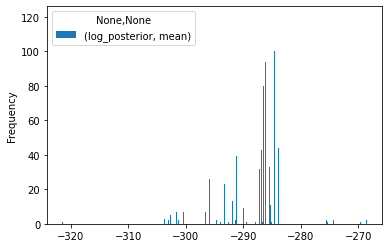

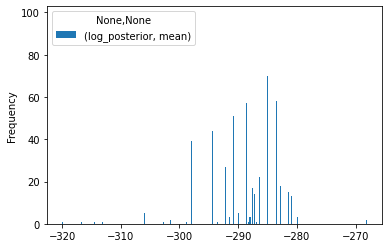

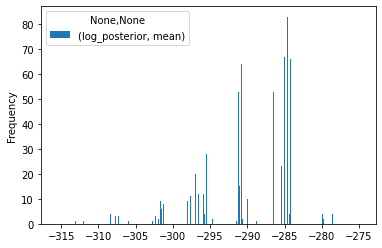

In [51]:
z_top.to_csv("")

### Convergence Results

In [61]:
z_top.groupby(["w_nc","trial"]).apply(lambda x: x.chain_rank.loc[x.index=="['No-norm', 'true']"].min())

w_nc  trial
0.00  1.0      1.0
      2.0      1.0
      3.0      1.0
0.05  1.0      1.0
      2.0      1.0
      3.0      3.0
0.10  1.0      2.0
      2.0      1.0
      3.0      3.0
0.15  1.0      1.0
      2.0      1.0
      3.0      1.0
0.20  1.0      1.0
      2.0      1.0
      3.0      1.0
0.25  1.0      1.0
      2.0      1.0
      3.0      1.0
0.30  1.0      1.0
      2.0      1.0
      3.0      1.0
0.35  1.0      1.0
      2.0      1.0
      3.0      2.0
0.40  1.0      1.0
      2.0      1.0
      3.0      1.0
0.45  1.0      1.0
      2.0      1.0
      3.0      2.0
0.50  1.0      1.0
      2.0      1.0
      3.0      1.0
0.55  1.0      1.0
      2.0      1.0
      3.0      1.0
dtype: float64

### Collate convergence

In [100]:
!touch "exp4_convergence.txt"

In [101]:
for exp_path in exp_paths:
    #w_nc,trial=tuple(map(lambda x: float(x.split("=")[-1]),exp_path.split(",")))
    !echo {exp_path} >> exp4_convergence.txt
    !cat {base_path+exp_path+"/conv_test_nc.txt"} >> exp4_convergence.txt
    !echo -e "\n ---" >> exp4_convergence.txt